#Preparations: install and load modules

In [67]:
!pip install ipympl

import matplotlib
%matplotlib widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, fftfreq
import skimage as si
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale, resize, downscale_local_mean
from numpy.linalg import norm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

# Zernike Phase Contrast



## First we prepare our phase object



image shape (256, 256)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

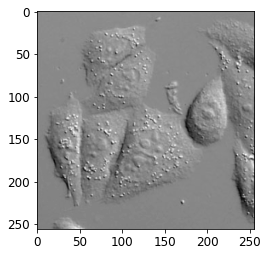

In [68]:
url = 'https://www.microscopyu.com/assets/gallery-images/Comparison/DIC_heladic.jpg'
import skimage
from skimage.io import imread

img_size = 256
image_numpy = imread( url )
cells = rescale(si.color.rgb2gray(image_numpy),0.8).astype(np.float32)[:img_size,:img_size]
# w = * window('hann', cells.shape)
# cells *= w
print('image shape', cells.shape)
fig, ax = plt.subplots()
ax.imshow(cells, cmap=plt.cm.get_cmap('gray'))
fig

## Then we define functions to make a phase-contrast image with a maximum absorption and phase contrast

In [33]:
def make_img(base_img, abs_max=0, phase_max = np.pi/100):
  b = base_img / base_img.max()
  ba = 1 - b * abs_max
  bph = b * phase_max
  res = ba * np.exp(1j * bph)  
  res = res.astype(np.complex64)
  return res

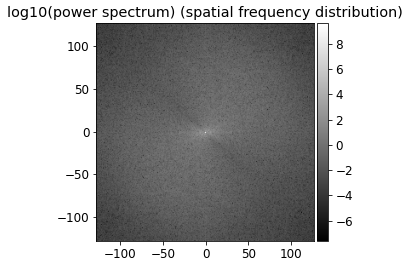

In [66]:
cell_power_spectrum = np.log10(fftshift(np.abs(fft2(make_img(cells)))**2))
n = cell_power_spectrum.shape
fig, ax = plt.subplots()
imax = ax.imshow(cell_power_spectrum, cmap=plt.cm.get_cmap('gray'), extent=(-n[0]/2,n[0]/2-1,-n[1]/2,n[1]/2-1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(imax, cax=cax)
ax.set_title('log10(power spectrum) (spatial frequency distribution)')
fig

## and a function to create a zernike phase-contrast image


In [51]:
def sector_mask(shape, centre, radius, angle_range=(0,360)):
    """
    Return a boolean mask for a circular sector. The start/stop angles in
    `angle_range` should be given in clockwise order.
    """

    x, y = np.ogrid[:shape[0], :shape[1]]
    cx, cy = centre
    tmin, tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
        tmax += 2 * np.pi

    # convert cartesian --> polar coordinates
    r2 = (x - cx) * (x - cx) + (y - cy) * (y - cy)
    theta = np.arctan2(x - cx, y - cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2 * np.pi)

    # circular mask
    circmask = r2 <= radius * radius

    # angular mask
    anglemask = theta <= (tmax - tmin)

    return circmask * anglemask

def zernike_contrast(x, radius=1):  
  fx = fft2(x)
  sh = np.array(x.shape)
  if radius == 1:
    plate = np.ones_like(fx)
    plate[0,0] = np.exp(1j * np.pi / 2)
  else:
    plate = np.ones_like(fx)
    mask = fftshift(sector_mask(sh, sh//2, radius))  
    plate[mask==1] = np.exp(1j * np.pi / 2)
  fx *= plate
  res = ifft2(fx)
  return res, plate

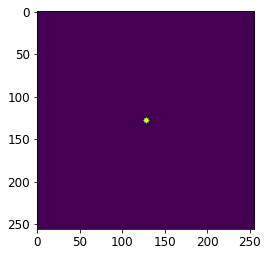

In [52]:
sh = np.array([256,256])
w = sector_mask(sh, sh//2,3)
fig, ax = plt.subplots()
ax.imshow(w)
fig

## Now switch on the Zernike phase plate interactively and change the phase and absorption contrast 



*   What happens with the zernike image once you increase the phase contrast to larger than $\pi$
*   What happens if you increase the size of the phase plate?



In [55]:
plt.ioff()

img = make_img(cells, abs_max=1, phase_max=np.pi)
abs_img = np.abs(img)
ang_img = np.angle(img)

zimg, plate = zernike_contrast(img)
s = img.shape[0]
fig, ax = plt.subplots(2,2, figsize=(8,8))
m = 100
imax00 = ax[0,0].imshow(abs_img, cmap=plt.cm.get_cmap('gray'))
ax[0,0].set_title('Abs')
imax01 = ax[0,1].imshow(ang_img, cmap=plt.cm.get_cmap('gray'))
ax[0,1].set_title('Phase')
imax10 = ax[1,0].imshow(np.ones_like(ang_img), cmap=plt.cm.get_cmap('gray'))
ax[1,0].set_title('Zernike Intensity')
imax11 = ax[1,1].imshow(fftshift(np.angle(plate))[m:-m,m:-m])
ax[1,1].set_title('Zernike Phase Plate')

divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(imax01, cax=cax)
cbar_ticks = np.linspace(ang_img.min(),ang_img.max(), num=6, endpoint=True)
cbar.set_ticks(cbar_ticks)

for axi in ax.ravel():
  axi.set_xticks([])
  axi.set_yticks([])

def update_plots(abs_max=1, phase_max=np.pi/20, zernike_on=False, zernike_radius=2):
    img = make_img(cells, abs_max=abs_max, phase_max=phase_max)
    if zernike_on:
      zimg, plate = zernike_contrast(img, radius=zernike_radius)
    else:
      zimg = img
      plate = np.ones_like(zimg)
    inten = np.abs(zimg)**2
    abs_img = np.abs(img)
    ang_img = np.angle(img)

    imax00.set_data(abs_img)
    imax01.set_data(ang_img)
    imax10.set_data(inten)

    imax01.set_clim(ang_img.min(),ang_img.max())

    cbar.set_clim(vmin=ang_img.min(),vmax=ang_img.max())
    cbar_ticks = np.linspace(ang_img.min(),ang_img.max(), num=6, endpoint=True)
    cbar.set_ticks(cbar_ticks) 
    cbar.draw_all() 

    imax10.set_clim(inten.min(),inten.max())
    imax11.set_data(fftshift(np.angle(plate))[m:-m,m:-m])
    fig.canvas.draw()
    fig.canvas.flush_events()
    return fig

# interact(f, x=10);
interact(update_plots, abs_max=widgets.FloatSlider(min=0, max=1, step=0.05, value=0, description='Max. absorption'), 
         phase_max=widgets.FloatSlider(min=0, max=2*np.pi, step=0.05, value=np.pi/20, description='Max. phase shift'),
         zernike_on=widgets.Checkbox(    value=False,    description='Insert Zernike plate',    disabled=False,    indent=False),
         zernike_radius=widgets.IntSlider(min=1, max=10, step=1, value=1, description='Zernike radius'));

interactive(children=(FloatSlider(value=0.0, description='Max. absorption', max=1.0, step=0.05), FloatSlider(v…

# Quantitative phase contrast - iterative reconstruction

In [69]:
def A(t, df, q, lam):
    """
    defocal series forward pass - apply a series of D defocus values in Fourier space and transform back to real space

    :param t: ny x nx, complex transmission image
    :param df: D defocus values
    :param q: 2 x ny x nx, q-vectors
    :param lam: wavelength
    :return: D x ny x nx, D defocused images
    """
    # wavevector norm
    q2 = norm(q, axis=0) ** 2
    # defocus phase plate
    chi = np.exp(1j * q2[None, ...] * lam * df[:, None, None])
    # fourier transform the sample
    ft = fft2(t, norm="ortho")
    # apply defocus
    hft = ft[None, ...] * chi
    # return to real space
    out = ifft2(hft, norm="ortho")
    return out

def At(z, df, q, lam):
    """
    defocal series backward pass - remove a series of D defocus values to D images in Fourier space and create a real-space image from them

    :param z: D x ny x nx
    :param df: D
    :param q: 2 x ny x nx, q-vectors
    :param lam:
    :return: ny x nx
    """

    q2 = norm(q, axis=0) ** 2
    chi = np.exp(1j * q2[None, ...] * lam * df[:, None, None])
    fz = ifft2(z, norm="ortho")
    hfz = fz * chi.conj()
    out = np.mean(fft2(hfz, norm="ortho"), 0)
    return out

In [70]:
a = cells
sig = 2
m2 = a.shape[0]
a = np.pad(a, (m2 // 4, m2 // 4), mode='constant', constant_values=np.mean(a))
a = gaussian_filter(a, sig)
t = np.exp(1j * np.pi * a / 8)

ft = fft2(t)
t = ifft2(ft)
ny, nx = t.shape

In [72]:
D = 4
lam = 1
df = np.linspace(100, 1300, D, dtype=np.float32)
dy, dx = 1, 1
qy = fftfreq(ny, dy)
qx = fftfreq(nx, dx)
q = np.array(np.meshgrid(qy, qx))


In [77]:


global model
global model_measurements
global measurements
global difference
measurements = np.abs(A(t, df, q, lam))
model = np.ones_like(np.angle(t))
model_measurements = np.abs(A(model, df, q, lam))**2
difference = np.angle(measurements-model_measurements)

ncols = 4

fig2 = plt.figure(constrained_layout=True, dpi=200)
widths = [1,1,1,1]
heights = [1,1,2,2,2]
spec2 = fig2.add_gridspec(ncols=ncols, nrows=5, wspace=0.3, hspace=0.3, width_ratios=widths, height_ratios=heights)
# spec2 = gridspec.GridSpec(ncols=ncols, nrows=3, figure=fig2)

target_ax = fig2.add_subplot(spec2[:2, :2])
model_ax = fig2.add_subplot(spec2[:2, 2:])
target_imax = target_ax.imshow(np.angle(t)[m2 // 4:-m2 // 4,m2 // 4:-m2 // 4])
target_ax.set_xticks([])
target_ax.set_yticks([])
target_ax.set_title('Target phase image')
model_imax = model_ax.imshow(model[m2 // 4:-m2 // 4,m2 // 4:-m2 // 4])
model_ax.set_xticks([])
model_ax.set_yticks([])
model_ax.set_title('Model phase image')
txt = model_ax.text(-100,100,'test')
measure_axes = []
model_axes = []
diff_axes = []

for i in range(ncols):
  model_axes.append(fig2.add_subplot(spec2[2, i]))
  measure_axes.append(fig2.add_subplot(spec2[3, i]))
  diff_axes.append(fig2.add_subplot(spec2[4, i]))

for i in range(ncols):
  model_axes[i].set_xticks([])
  model_axes[i].set_yticks([])
  model_axes[i].set_title(f'model measurement {i:02d}')
  measure_axes[i].set_xticks([])
  measure_axes[i].set_yticks([])
  measure_axes[i].set_title(f'measurement {i:02d}')
  diff_axes[i].set_xticks([])
  diff_axes[i].set_yticks([])
  diff_axes[i].set_title(f'difference {i:02d}')

measure_imaxes = []
for i, m_ax in enumerate(measure_axes):
  measure_imaxes.append(m_ax.imshow(measurements[i]))
model_imaxes = []
for i, m_ax in enumerate(model_axes):
  model_imaxes.append(m_ax.imshow(model_measurements[i]))

global update_measurement1_old 
update_measurement1_old = False

def update_plots(reset=False,
                 update_measurement1=False,
                 run_iterations=False):
    global update_measurement1_old 
    global model
    global model_measurements
    global measurements
    global difference
    if reset:
      pass

    update = False
    if update_measurement1 != update_measurement1_old:
      txt.set_text('1')
      update = True
      i = 0
      update_measurement1_old = update_measurement1
      m = A(model, df, q, lam)      
      m *= measurements/np.abs(m)      
            
    if update:
      model = At(m, df, q, lam)
      am = np.angle(model)[m2 // 4:-m2 // 4,m2 // 4:-m2 // 4]
      model_imax.set_data(am)
      model_imax.set_clim(am.min(),am.max())

    if run_iterations:
      for i in range(50):
        m = A(model, df, q, lam)      
        m *= measurements/np.abs(m)   
        model = At(m, df, q, lam)   
        if i % 5 == 0:
          txt.set_text(f'{i:02d}')   
          fig2.canvas.draw()
          fig2.canvas.flush_events()
          am = np.angle(model)[m2 // 4:-m2 // 4,m2 // 4:-m2 // 4]
          model_imax.set_data(am)
          model_imax.set_clim(am.min(),am.max())
      
    fig2.canvas.draw()
    fig2.canvas.flush_events()
    return fig2
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 4}

matplotlib.rc('font', **font)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [78]:
interact(update_plots, reset=widgets.ToggleButton(value=False,description='Reset Model'),
                 update_measurement1=widgets.ToggleButton(value=False,description='Enforce meas. 1'),
                 run_iterations=widgets.ToggleButton(value=False,description='Run 50 iterations'));

interactive(children=(ToggleButton(value=False, description='Reset Model'), ToggleButton(value=False, descript…